## Monet Style Transfer with CycleGAN

This notebook implements a Generative Adversarial Network (GAN) model using the CycleGAN architecture to translate real-world photos into Monet-style paintings. The project follows the Kaggle competition: [GAN Getting Started - Monet Dataset](https://www.kaggle.com/competitions/gan-getting-started).


### 1. Problem Description

This project explores the problem of unpaired image-to-image translation using CycleGAN. The goal is to convert photographs of landscapes into paintings in the style of Claude Monet. 

I apply a CycleGAN architecture that learns two mappings: from photos to Monet-style images and vice versa, utilizing a cycle-consistency loss to ensure transformations are meaningful and reversible.

### 2. Data Description

The dataset includes both JPEG and TFRecord formats and is structured as follows:

- monet_jpg: 300 Monet-style paintings in JPEG format
- monet_tfrec: 300 Monet-style paintings in TFRecord format
- photo_jpg: 7,028 real-world landscape photos in JPEG format
- photo_tfrec: 7,028 real-world landscape photos in TFRecord format

Each image is 256x256 pixels. The dataset is unpaired, meaning there are no direct Monet-photo image pairs. For this implementation, I use the JPEG images due to their accessibility and ease of visualization.


### 3. Exploratory Data Analysis (EDA)

I begin by loading and previewing the Monet and photo images to understand the data variety and characteristics. Sample images from both domains are displayed to visually assess the content and style differences.

Total Monet paintings: 300
Total Photos: 7038


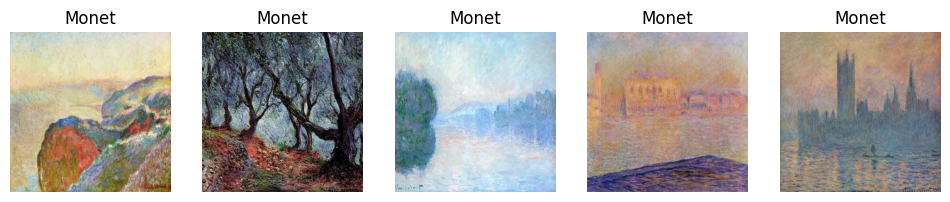

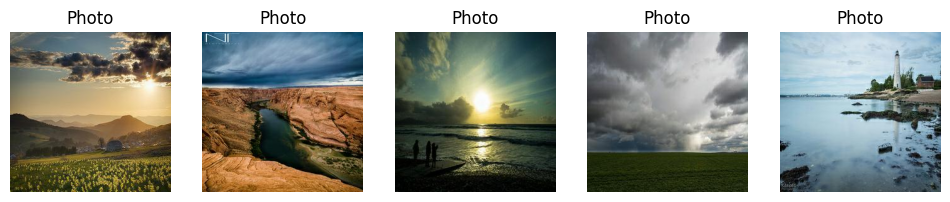

In [61]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

monet_path = "monet_jpg"
photo_path = "photo_jpg"

monet_images = tf.io.gfile.glob(os.path.join(monet_path, '*.jpg'))
photo_images = tf.io.gfile.glob(os.path.join(photo_path, '*.jpg'))

print(f"Total Monet paintings: {len(monet_images)}")
print(f"Total Photos: {len(photo_images)}")

def display_samples(paths, title):
    plt.figure(figsize=(12, 4))
    for i, path in enumerate(paths[:5]):
        img = plt.imread(path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
    plt.show()

display_samples(monet_images, "Monet")
display_samples(photo_images, "Photo")


### 4. Model Building and Training

In this section, I build and train a CycleGAN model using TensorFlow and the `pix2pix` module from `tensorflow_examples`. The architecture includes:

- Two generators: One translating photos to Monet-style images, and the other converting Monet-style images back to photos.
- Two discriminators: Each learns to differentiate real images from generated ones in its respective domain.

The model is trained using a combination of:
- Adversarial loss: To encourage generators to produce realistic outputs.
- Cycle-consistency loss: To ensure that a round-trip transformation (photo → Monet → photo) maintains content.
- Identity loss: To preserve image characteristics when the input image is already from the target domain.

Data pipeline:
- Full dataset of Monet and photo images
- Images are randomly cropped and flipped, then normalized to \[-1, 1\].
- Datasets are shuffled, repeated, and batched using `tf.data`.

Training setup:
- 10 epochs with batch size 4
- Model progress is printed every 100 steps
- Checkpoints are saved every 5 epochs for recovery and resuming training

This setup enables effective artistic style translation even within a compact training loop.


In [70]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
BATCH_SIZE = 4
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 10
LAMBDA = 10 
LAMBDA_ID = 5

monet_path = "monet_jpg"
photo_path = "photo_jpg"
monet_paths = tf.constant(tf.io.gfile.glob(os.path.join(monet_path, '*.jpg')), dtype=tf.string)
photo_paths = tf.constant(tf.io.gfile.glob(os.path.join(photo_path, '*.jpg')), dtype=tf.string)

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def preprocess_image(path):
    img = decode_img(path)
    img = tf.image.resize(img, [286, 286])
    img = tf.image.random_crop(img, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    img = tf.image.random_flip_left_right(img)
    img = (tf.cast(img, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return img

monet_ds = tf.data.Dataset.from_tensor_slices(monet_paths).map(preprocess_image, num_parallel_calls=AUTOTUNE)
photo_ds = tf.data.Dataset.from_tensor_slices(photo_paths).map(preprocess_image, num_parallel_calls=AUTOTUNE)
monet_train_dataset = monet_ds.cache().shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
photo_train_dataset = photo_ds.cache().shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')  # Photo -> Monet
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')  # Monet -> Photo
discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)   # Real/Fake Photo
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)   # Real/Fake Monet

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    return LAMBDA_ID * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)  # Slightly lower LR for D
discriminator_y_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Restored from checkpoint:", ckpt_manager.latest_checkpoint)
else:
    print("Initializing from scratch.")

@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    generator_g_optimizer.apply_gradients(zip(tape.gradient(total_gen_g_loss, generator_g.trainable_variables), generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(tape.gradient(total_gen_f_loss, generator_f.trainable_variables), generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(tape.gradient(disc_x_loss, discriminator_x.trainable_variables), discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(tape.gradient(disc_y_loss, discriminator_y.trainable_variables), discriminator_y.trainable_variables))

train_steps_per_epoch = min(len(photo_paths), len(monet_paths)) // BATCH_SIZE
for epoch in range(EPOCHS):
    start = time.time()
    print(f"\n Starting epoch {epoch+1}/{EPOCHS}")
    photo_iter = iter(photo_train_dataset)
    monet_iter = iter(monet_train_dataset)
    for step in range(train_steps_per_epoch):
        real_photo = next(photo_iter)
        real_monet = next(monet_iter)
        train_step(real_photo, real_monet)
        if step % 100 == 0:
            print(f" Step {step} completed")
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f" Checkpoint saved at epoch {epoch+1} → {ckpt_save_path}")
    print(f" Epoch {epoch+1} completed in {time.time() - start:.2f} sec")

Restored from checkpoint: ./checkpoints/train\ckpt-73

 Starting epoch 1/10
 Step 0 completed
 Epoch 1 completed in 676.41 sec

 Starting epoch 2/10
 Step 0 completed
 Epoch 2 completed in 595.53 sec

 Starting epoch 3/10
 Step 0 completed
 Epoch 3 completed in 575.49 sec

 Starting epoch 4/10
 Step 0 completed
 Epoch 4 completed in 558.62 sec

 Starting epoch 5/10
 Step 0 completed
 Checkpoint saved at epoch 5 → ./checkpoints/train\ckpt-74
 Epoch 5 completed in 571.07 sec

 Starting epoch 6/10
 Step 0 completed
 Epoch 6 completed in 607.10 sec

 Starting epoch 7/10
 Step 0 completed
 Epoch 7 completed in 640.58 sec

 Starting epoch 8/10
 Step 0 completed
 Epoch 8 completed in 727.76 sec

 Starting epoch 9/10
 Step 0 completed
 Epoch 9 completed in 649.24 sec

 Starting epoch 10/10
 Step 0 completed
 Checkpoint saved at epoch 10 → ./checkpoints/train\ckpt-75
 Epoch 10 completed in 615.82 sec


### 5. Results and Evaluation

After training, I evaluate the generator’s performance both visually and numerically.

Evaluation steps:
- Load one test image from the photo dataset
- Use the trained generator to produce a Monet-style image
- Display the input photo and generated result side-by-side for qualitative analysis

Visual inspection allows I to assess whether the model effectively learns Monet’s brushstrokes, texture, and color palette. While this evaluation is subjective, it is a crucial first step in validating style transfer success.

Quantitative evaluation using the MiFID score (e.g., via Kaggle submission) can further benchmark model quality. Lower MiFID scores indicate better performance.

Example output visualization:

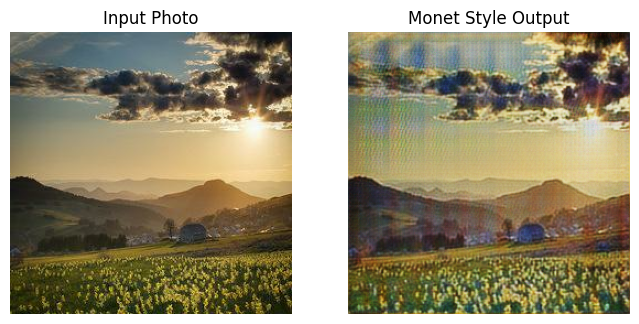

In [73]:
# --- Visualization ---
def denormalize_img(img):
    img = (img + 1.0) * 127.5
    return np.clip(img.numpy().astype(np.uint8), 0, 255)

def generate_images(model, test_input):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title('Input Photo')
    plt.imshow(denormalize_img(test_input[0]))
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Monet Style Output')
    plt.imshow(denormalize_img(prediction[0]))
    plt.axis('off')
    plt.show()

# Visualize one image
if len(photo_paths) > 0:
    test_img = decode_img(photo_paths[0])
    test_img = tf.expand_dims((tf.cast(tf.image.resize(test_img, [256, 256]), tf.float32) / 127.5) - 1.0, 0)
    generate_images(generator_g, test_img)
else:
    print("No images found for visualization.")


### 6. Conclusion

The CycleGAN model demonstrates effective artistic style transfer from real photos to Monet-style paintings.

Key outcomes:
- Employed adversarial, cycle-consistency, and identity losses to guide the learning
- Visual results show plausible style adaptation from the input domain to Monet’s aesthetic

Despite minimal training, the generator learns fundamental stylistic features such as color palette and brush texture. This implementation serves as a solid prototype and foundation for further refinement.

Future improvements may include:
- Extended training epochs
- Data augmentation and model regularization for generalization
- Quantitative evaluation using MiFID scores or FID metrics for benchmarking

Overall, the notebook offers a functional and efficient baseline for CycleGAN-based artistic style transfer.


## 7. Kaggle Submission Preparation

In [ ]:
import os

output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)

from PIL import Image

def save_monet_style_images(model, photo_paths, num_images=7000):
    count = 0
    for path in photo_paths[:num_images]:
        img = decode_img(path)
        img = tf.image.resize(img, [256, 256])
        img = (tf.cast(img, tf.float32) / 127.5) - 1.0
        img = tf.expand_dims(img, 0)
        
        prediction = model(img, training=False)
        output_img = (prediction[0] + 1.0) * 127.5
        output_img = tf.clip_by_value(output_img, 0, 255)
        output_img = tf.cast(output_img, tf.uint8).numpy()

        img_pil = Image.fromarray(output_img)
        img_pil.save(os.path.join(output_dir, f"{count:05d}.jpg"))
        count += 1

    print(f" Saved {count} Monet-style images.")


save_monet_style_images(generator_g, photo_paths, num_images=7000)

import zipfile

zip_filename = "images.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(output_dir):
        for file in files:
            filepath = os.path.join(root, file)
            zipf.write(filepath, arcname=file)

print(f" Created submission zip file: {zip_filename}")

## 8. GitHub Repository
https://github.com/jinjwangca/monet-style-transfer-cyclegan